# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 2 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-09-13 12:23:17.042 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-13 12:23:17.044 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-09-13 12:23:17.051 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-09-13 12:23:17.055 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-13 12:23:21.331 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions


2025-09-13 12:23:26 | INFO     | AFML v1.0.0 ready - 10 heavy modules available for lazy loading
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import copy
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier

from afml.backtest_statistics import (
    calculate_performance_metrics,
    compare_pr_curves,
    compare_roc_curves,
    compare_roc_pr_curves,
    get_optimal_threshold,
    meta_labelling_classification_report_images,
    meta_labelling_classification_report_tables,
    meta_labelling_reports,
    run_meta_labeling_analysis,
)
from afml.bet_sizing.bet_sizing import bet_size_probability
from afml.cache import cache_maintenance, clear_afml_cache, selective_cache_clear
from afml.data_structures.bars import *
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    get_event_weights,
    trend_scanning_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    plot_bbands,
    plot_bbands_dual_bbp_bw,
)
from afml.strategies.training import train_meta_model
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [3]:
pprint(cache_maintenance(), sort_dicts=False)
# clear_afml_cache()

2025-09-13 12:23:28 | INFO     | No function changes detected
2025-09-13 12:23:29 | INFO     | Cache maintenance completed: 10 functions checked
{'functions_checked': 10,
 'changed_functions': [],
 'cleared_functions': [],
 'size_cleared_mb': 0,
 'old_files_removed': 0}


## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date

In [5]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [6]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


In [7]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, 50)
bb_vol_multiplier = 1

### Time-Bars

In [8]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close

thres = vol_target.mean()
print(f"CUSUM filter threshold: {thres:.4%}")

t_events = cusum_filter(close, thres)
N = bb_side[bb_side != 0].shape[0]

print(f"\n{bb_strategy.get_strategy_name()} CUSUM-Filtered Signals:")
value_counts_data(bb_side.reindex(t_events), verbose=True)

t_events = t_events.intersection(bb_side[bb_side != 0].index)
print(f"t_events: {t_events.size:,} / {N:,} = {t_events.size / N:.2%}")
vertical_barriers = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)
linear_decay = False

Bollinger_w20_std1.5 Signals:

        count  proportion
side                     
 0    198,417    0.671105
-1     48,987    0.165689
 1     48,253    0.163206

CUSUM filter threshold: 0.1425%
2025-09-13 12:23:33 | INFO     | 9,708 CUSUM-filtered events

Bollinger_w20_std1.5 CUSUM-Filtered Signals:

      count  proportion
side                   
 1    3,974    0.409353
-1    3,860    0.397610
 0    1,874    0.193037

t_events: 7,834 / 168,331 = 4.65%


In [9]:
# start = "2018-01-13 06:00"
# end = "2018-02-01 06:00"
# close_ = close.loc[start:end]
# t_events_ = t_events.intersection(close_.index)

# fig, ax = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[3,2], sharex=True)

# close_.plot(ax=ax[0], legend=True, ylabel="Price", linewidth=1, grid=True, alpha=0.7)
# ax[0].scatter(t_events_, close_.reindex(t_events_), marker='x', color='red', s=40)
# (vol_target.reindex(close_.index) * 100).plot(ax=ax[1], legend=True, ylabel=r"% $\sigma$", label=fr"$\sigma$ Daily EWM({vol_lookback})", linewidth=1, grid=True)

# fig.suptitle(f"{symbol} - {bb_timeframe}", fontsize=13)
# plt.subplots_adjust(top=0.9)

#### Feature Engineering

In [10]:
bb_feat = create_bollinger_features(bb_time_bars, bb_lookback, bb_period, bb_std)
bb_feat_time = bb_feat.shift().dropna()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 513293 entries, 2018-01-19 07:40:00 to 2024-12-31 00:00:00
Data columns (total 52 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   close             513293 non-null  float32
 1   spread            513293 non-null  float32
 2   bb_lower          513293 non-null  float32
 3   bb_mid            513293 non-null  float32
 4   bb_upper          513293 non-null  float32
 5   bb_bandwidth      513293 non-null  float32
 6   bb_percentage     513293 non-null  float64
 7   ret               513293 non-null  float32
 8   ret_5             513293 non-null  float32
 9   ret_10            513293 non-null  float32
 10  ret_1_lag_1       513293 non-null  float32
 11  ret_5_lag_1       513293 non-null  float32
 12  ret_10_lag_1      513293 non-null  float32
 13  ret_1_lag_2       513293 non-null  float32
 14  ret_5_lag_2       513293 non-null  float32
 15  ret_10_lag_2      513293 non-null 

#### Fixed-Time Horizon Method

In [11]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
bb_events_fh_time = bb_events_fh.copy()
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)

av_uniqueness = bb_events_fh['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Fixed-Time Horizon (h=50):

     count  proportion
bin                   
1    4,046    0.516995
0    3,780    0.483005

Average Uniqueness: 0.5397


#### Triple-Barrier Method

In [12]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=0,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_time = bb_events_tbl.copy()

print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tbl.bin, verbose=True)

av_uniqueness = bb_events_tbl['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=50):

     count  proportion
bin                   
1    4,467     0.57079
0    3,359     0.42921

Average Uniqueness: 0.7018


#### Trend-Scanning Method

In [15]:
span = (5, bb_time_horizon + 1)
volatility_threshold = 0.25
side = bb_side.reindex(t_events)

In [ ]:
trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = trend_events.reindex(t_events.intersection(trend_events.index))
print(f"Trend-Scanning (σ = {volatility_threshold}) \n{'-'*40}")
value_counts_data(trend_events.bin, verbose=True)

print(f"\nTriple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}) \n{'-'*40}")
av_uniqueness = bb_events_tbl_time['tW'].mean()
value_counts_data(bb_events_tbl_time.bin, verbose=True)
print(f"Average Uniqueness: {av_uniqueness:.4f}")

bb_events_trend = bb_events_tbl_time.join(trend_events[['window', 't_value']], how="inner")
# bb_events_trend["bin"] = bb_events_trend["bin"].where(trend_events['bin'] == 0, 0)
bb_events_trend["bin"] = bb_events_trend["bin"].where(trend_events['bin'] == side.reindex(trend_events.index), 0)
bb_events_trend_time = bb_events_trend.copy()
print(f"\nTrend-Scanning Meta-Labels (σ = {volatility_threshold})" \
      f" \n{'-'*40} \n{value_counts_data(bb_events_trend.bin)}")

In [ ]:
# bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()
print(f"Trend-Scanning Meta-labels (σ = {volatility_threshold}):")
value_counts_data(bb_events_trend.bin, verbose=True)

events = bb_events_trend[bb_events_trend.bin == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = events["ret"].mean() * 100

fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Time-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [13]:
dashes = "-" * 60
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 12
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: Bollinger_w20_std1.5


##### Unweighted

2025-09-13 12:23:54 | INFO     | Samples are equally weighted.
2025-09-13 12:23:55 | INFO     | Training on 5,384 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1096
           1       0.53      1.00      0.69      1213

    accuracy                           0.53      2309
   macro avg       0.26      0.50      0.34      2309
weighted avg       0.28      0.53      0.36      2309


Confusion Matrix:
[[   0 1096]
 [   0 1213]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      1096
           1       0.53      0.50      0.51      1213

    accuracy      

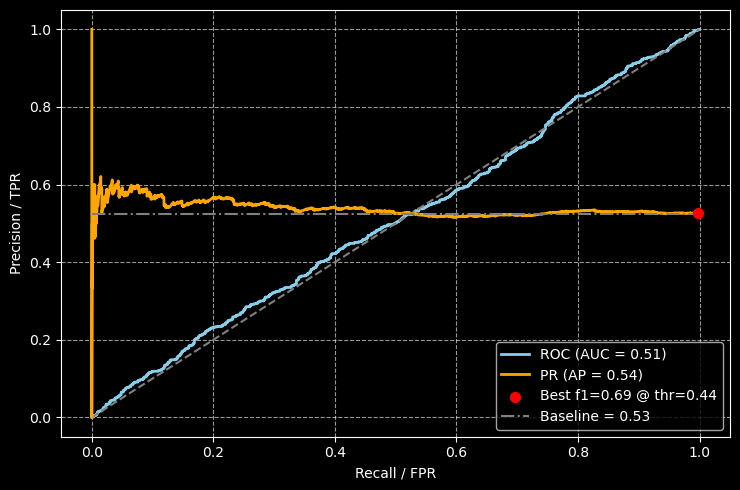

In [14]:
model_bb_fh_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time, plot=True)

2025-09-13 12:24:17 | INFO     | Samples are equally weighted.
2025-09-13 12:24:17 | INFO     | Training on 5,385 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       964
           1       0.58      1.00      0.74      1345

    accuracy                           0.58      2309
   macro avg       0.29      0.50      0.37      2309
weighted avg       0.34      0.58      0.43      2309


Confusion Matrix:
[[   0  964]
 [   0 1345]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.29      0.35       964
           1       0.60      0.75      0.67      1345

    accuracy          

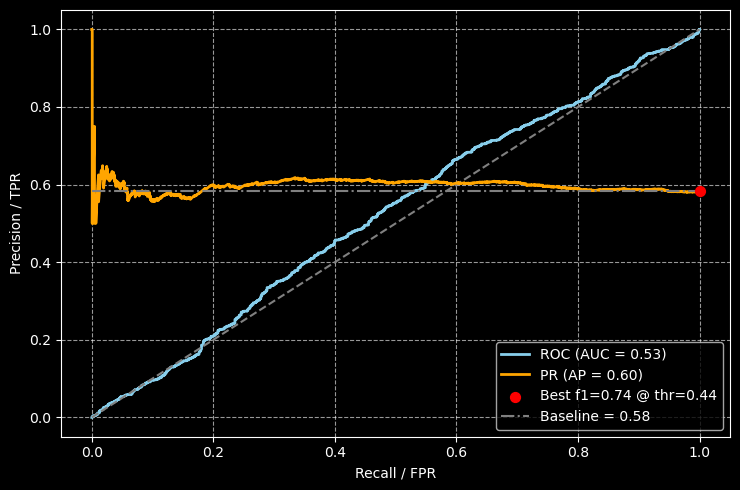

In [15]:
model_bb_tbl_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time, plot=True)

In [ ]:
# model_bb_trend_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time)
# print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
# summary = meta_labelling_reports(model_bb_trend_time, plot=True)

##### Return-Weighted

In [ ]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_w, plot=True)

In [ ]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_w, plot=True)

In [ ]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_w, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

# Simulated loop over labeling methods
labeling_methods = [
    "fixed-horizon", 
    "triple-barrier", 
    "trend-scanning", 
    ]
models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]

In [ ]:
# fp = Path(dirpath, "unweighted")
# fp_plots = Path(dirpath, "plots", "unweighted")
# fp_plots.mkdir(parents=True, exist_ok=True)
# bb_models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]

# bb_roc = compare_roc_curves(
#     bb_models[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
# # bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
# # bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png", bbox_inches="tight", dpi=100)

# # meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
# fp_w = Path(dirpath, "return_weighted") 
# fp_plots = Path(dirpath, "plots", "return_weighted")
# fp_plots.mkdir(parents=True, exist_ok=True)

# bb_models_w = [model_bb_fh_time_w, model_bb_tbl_time_w, model_bb_trend_time_w]
# bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
# filenames_w = [f"{w}_w" for w in filenames]

# bbb_roc = compare_roc_curves(
#     bb_models_w[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
# fp_tw = Path(dirpath, "time_weighted") 
# plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
# columns = 2
# height = 7.5
# fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

# bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
# for time_decay, labels in models_bb_time_tw.items():
#     for i, (label, model) in enumerate(labels.items()):
#         bb_models_tw.append(model)
#         bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
#         filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

# meta_labelling_classification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)

# fig_title = fig_titles[0]
# bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
# bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png", bbox_inches="tight", dpi=100)

##### Out-of-Sample

In [30]:
bb_model_results_time = {}
time_metrics_oos = {}

df = bb_time_bars[sample_end:]
close = df.close
target = get_daily_vol(close, vol_lookback) * bb_vol_multiplier
data_index = target.dropna().index

_, t_events = get_entries(bb_strategy, df.reindex(data_index), on_crossover=True)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

# Create feature set for model
X_test = bb_feat_time.join(bb_side).reindex(t_events).dropna()
value_counts_data(X_test.side, verbose=True)
X_test.info()

2025-09-13 12:49:49 | INFO     | Generated 23,876 trade events generated by crossover.

       count  proportion
side                    
-1    11,975     0.50155
 1    11,901     0.49845

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23876 entries, 2022-01-03 01:45:00 to 2024-12-30 23:55:00
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             23876 non-null  float32
 1   spread            23876 non-null  float32
 2   bb_lower          23876 non-null  float32
 3   bb_mid            23876 non-null  float32
 4   bb_upper          23876 non-null  float32
 5   bb_bandwidth      23876 non-null  float32
 6   bb_percentage     23876 non-null  float64
 7   ret               23876 non-null  float32
 8   ret_5             23876 non-null  float32
 9   ret_10            23876 non-null  float32
 10  ret_1_lag_1       23876 non-null  float32
 11  ret_5_lag_1       23876 non-null  float32
 12  ret_

In [31]:
model = model_bb_fh_time
prob = pd.Series(model.fit.predict_proba(X_test)[:, 1], index=X_test.index)
# confidence_threshold = get_optimal_threshold(model)

events = triple_barrier_labels(
    close, target, t_events, vertical_barrier_times, 
    side_prediction=bb_side, 
    pt_sl=[0, 0], 
    vertical_barrier_zero=False, 
    drop=False,
    verbose=False,
    )


results = run_meta_labeling_analysis(
    data_index,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"fixed_horizon_{bb_time_horizon}"] = results

ValueError: Length mismatch: Expected axis has 344 elements, new values have 345 elements

In [24]:
# # --- Bet Sizing Logic ---
bet_sizes_raw = bet_size_probability(
    events,
    prob,
    num_classes=2,
    pred=events.side,
    # step_size=step_size,
    # average_active=average_active,
)
sum(bet_sizes_raw == 0)

ValueError: operands could not be broadcast together with shapes (23870,) (23876,) 

In [29]:
model = model_bb_tbl_time
prob = pd.Series(model.fit.predict_proba(X_test)[:, 1], index=X_test.index)
# confidence_threshold = get_optimal_threshold(model)

events = triple_barrier_labels(
    close, target, t_events, vertical_barrier_times, 
    side_prediction=bb_side, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier], 
    vertical_barrier_zero=False, 
    drop=False,
    verbose=False,
    )


results = run_meta_labeling_analysis(
    data_index,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"triple_barrier_{bb_pt_barrier}_{bb_sl_barrier}_{bb_time_horizon}"] = results

ValueError: Length mismatch: Expected axis has 515 elements, new values have 516 elements

In [ ]:
model = model_bb_trend_time
prob = pd.Series(model.fit.predict_proba(X_test)[:, 1], index=X_test.index)
# confidence_threshold = get_optimal_threshold(model)

results = run_meta_labeling_analysis(
    data_index,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"trend_scanning_{volatility_threshold}"] = results

In [ ]:
# # meta_positions = (prob > 0.44).astype("int8")
# # value_counts_data(meta_positions)
# fit = model_bb_fh_time.fit
# prob = pd.Series(fit.predict_proba(X_test)[:, 1], index=X_test.index)

# bet_sizes_raw = bet_size_probability(
#         events,
#         prob,
#         num_classes=2,
#         pred=events['side'],
#         step_size=0,
#         average_active=0,
#     )
# bet_sizes_raw.describe()

### Tick-Bars

In [ ]:
bb_df = bb_tick_bars.loc[sample_start : sample_end]
bb_side = bb_strategy.generate_signals(bb_tick_bars)
close = bb_df.close

# Volatility target for barriers
vol_target = get_daily_vol(close, lookback=bb_period) * bb_vol_multiplier
thres = vol_target.mean()
print(f"CUSUM filter threshold: {thres:.4%}")

t_events = cusum_filter(close, thres)
t_events = t_events.intersection(bb_side[bb_side != 0].index)
print(f"t_events: {t_events.size:,}")

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(bb_timeframe) if x.isnumeric()))
bb_tick_horizon = bb_time_horizon * tm
if bb_timeframe.startswith("H"):
    bb_tick_horizon *= 60
elif bb_timeframe.startswith("D"):
    bb_tick_horizon *= 60 * 24

h = timedelta(minutes=bb_tick_horizon)
print(f"Time Horizon: {h}")
vertical_barriers_bars = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)
vertical_barriers_time = add_vertical_barrier(t_events, close, minutes=bb_tick_horizon)

#### Feature Engineering

In [ ]:
# No shifting b/c mean-reversion seems to benefit from contemporaneous information
bb_feat = create_bollinger_features(bb_tick_bars, bb_lookback, bb_period, bb_std)
bb_feat.info()

bb_feat_tick = bb_feat.copy()
# not_stationary = is_stationary(bb_feat_tick.dropna())

#### Fixed-Time Horizon Method

In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_bars,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)

bb_events_fh_tick = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
print(f"Fixed-Time Horizon (h={h}):")
value_counts_data(bb_events_fh.bin, verbose=True)

bb_events_fh_tick1 = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

#### Triple-Barrier Method

In [ ]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_bars,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_tick = bb_events_tbl.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tbl.bin, verbose=True)


ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

In [ ]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_tick1 = bb_events_tbl.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={h}):")
value_counts_data(bb_events_tbl.bin, verbose=True)


ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

#### Trend-Scanning Method

In [ ]:
span = (5, bb_time_horizon + 1)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85
side = bb_side.reindex(close.index)

In [ ]:
bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_tick = bb_events_trend.copy()
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()


print(f"Bollinger_w{bb_period}_std{bb_std}:")
print(f"bb_events_trend.shape: {bb_events_trend.shape}\n")

print(f"trend_scanning_meta_labels {volatility_threshold}: \n{value_counts_data(bb_events_trend.bin)}\n")

events = bb_events_trend[bb_events_trend.bin == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = events["ret"].mean() * 100
fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Tick-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [ ]:
dashes = "-" * 60
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 52
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

##### Unweighted

In [ ]:
model_bb_fh_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_tick, plot=True)

In [ ]:
model_bb_tbl_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_tick, plot=True)

In [ ]:
model_bb_trend_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_tick, plot=True)

In [ ]:
model_bb_trend_mr_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_tick, plot=True)

##### Return-Weighted

In [ ]:
model_bb_fh_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_tick_w, plot=True)

In [ ]:
model_bb_tbl_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_tick_w, plot=True)

In [ ]:
model_bb_trend_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_tick_w, plot=True)

In [ ]:
model_bb_trend_mr_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_tick_w, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "tick_bars", f"tick-{bb_tick_bars.tick_volume.iloc[0]}")
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

In [ ]:
bb_models = [model_bb_fh_tick, model_bb_tbl_tick, model_bb_trend_tick, model_bb_trend_mr_tick]
fp = Path(dirpath, "unweighted") 
fp.mkdir(parents=True, exist_ok=True)

fp_plots = Path(dirpath, "plots", "unweighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc = compare_roc_curves(
    bb_models[:], plot_titles[:], columns=2, height=7.5, 
    fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
    )
bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)


meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
fp_w = Path(dirpath, "return_weighted") 
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

fp_plots = Path(dirpath, "plots", "return_weighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc_w = compare_roc_curves(bb_models_w[:], plot_titles[:], columns=2, height=7.5, fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)")
bb_roc_w.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

##### Out-of-Sample

In [ ]:
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
model_preds_tick_w = {}
tick_metrics_oos_w = {}
X = bb_feat_tick.loc[sample_end:]
df_oos = bb_tick_bars.loc[sample_end:]

for i, model in enumerate(bb_models_w):
    df, metrics = backtest_model(model.fit, X, df_oos.close)
    model_preds_tick_w[bb_titles[i]] = df
    tick_metrics_oos_w[filenames[i]] = metrics
    print(f"{bb_titles[i]} done.")

tick_metrics_oos_df_w = pd.DataFrame(tick_metrics_oos_w)
tick_metrics_oos_df_w

#### Time- vs. Tick-Bars

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
pr = compare_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Time-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_time, model_bb_tbl_time] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
metric = "f1"
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Tick-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_tick, model_bb_tbl_tick] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df.round(2)
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

## 3. Moving Average Crossover Strategy

In [ ]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M30"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (4, 1.5, 100)
ma_vol_multiplier = 0.3
time_decay = 0.3
linear_decay = False

### Time-Bars

In [ ]:
ma_df = ma_time_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=fast_window).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

ma_side = ma_strategy.generate_signals(ma_df)
vertical_barriers = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)

#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_time = ma_feat.copy()
ma_feat.info()

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_time = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_time = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

close = ma_df.close
vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_time = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_time = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Tick-Bars

In [ ]:
ma_df = ma_tick_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
ma_side = ma_strategy.generate_signals(ma_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(ma_timeframe) if x.isnumeric()))
ma_tick_horizon = ma_time_horizon * tm
if ma_timeframe.startswith("H"):
    ma_tick_horizon *= 60
elif ma_timeframe.startswith("D"):
    ma_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=tm)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=ma_tick_horizon)

#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_tick = ma_feat.copy()
ma_feat.info()

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_tick = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_tick = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_tick = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_tick = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Random Forest

In [ ]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )
time_decay = 0.3

##### Time-Bars

In [ ]:
model_ma_fh_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_fh_time.y_test, model_ma_fh_time.w_test, model_ma_fh_time.pred, model_ma_fh_time.prob, plot=True
    )

In [ ]:
model_ma_tbl_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_tbl_time.y_test, model_ma_tbl_time.w_test, model_ma_tbl_time.pred, model_ma_tbl_time.prob, plot=True
    )

In [ ]:
model_ma_trend_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_trend_time.y_test, model_ma_trend_time.w_test, model_ma_trend_time.pred, model_ma_trend_time.prob, plot=True
    )

In [ ]:
model_ma_trend_mr_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_mr_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_trend_mr_time.y_test, model_ma_trend_mr_time.w_test, model_ma_trend_mr_time.pred, model_ma_trend_mr_time.prob, plot=True
    )

###### Return-Weighted

In [ ]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_w, plot=True)

In [ ]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_w, plot=True)

In [ ]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_w, plot=True)

In [ ]:
model_bb_trend_mr_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_time_w, plot=True)

###### Time-Decay Weighted

In [ ]:
model_bb_fh_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_fh_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_tw, plot=True)

In [ ]:
model_bb_tbl_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_tbl_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_tw, plot=True)

In [ ]:
model_bb_trend_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_tw, plot=True)

In [ ]:
model_bb_trend_mr_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_time_tw, plot=True)

Reports

In [ ]:
dirpath = Path("reports", "time_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_time_horizon})", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_time, model_ma_tbl_time, model_ma_trend_time, model_ma_trend_mr_time]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=model_ma_fh_time, title="Fixed-Time Horizon", output_filename=dirpath / "ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl_time, title="Triple Barrier", output_filename=dirpath / "ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend_time, title=f"Trend-Scanning (σ = {volatility_threshold})", 
                                      output_filename=dirpath / "ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_mr_time, title=f"Trend-Scanning (σ = {volatility_threshold_mr})", 
                                      output_filename=dirpath / "ma_trend_scanning_mr")

##### Tick-Bars

In [ ]:
model_ma_fh_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_fh_tick, plot=True)

In [ ]:
model_ma_tbl_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_tbl_tick, plot=True)

In [ ]:
model_ma_trend_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_trend_tick, plot=True)

In [ ]:
model_ma_trend_mr_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_trend_mr_tick, plot=True)

In [ ]:
dirpath = Path("reports", "tick_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_tick_horizon} minutes)", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_tick_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_tick, model_ma_tbl_tick, model_ma_trend_tick, model_ma_trend_mr_tick]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=ma_models, title=bb_titles, output_filename=dirpath / "ma_fixed_tick")